# Cavity-QED modelling

https://qutip.org/docs/latest/guide/guide-visualization.html

In [3]:
using Pkg; Pkg.activate("..")

In [4]:
using QuantumOptics
using LinearAlgebra
using Plots
using Measures
gr(display_type=:inline)
# plotlyjs()

Plots.GRBackend()

In [5]:
function thermal_dm(basis, n)
    i = 0:basis.N
    SparseOperator(b_fock, Diagonal((1.0 + n)^(-1.0) * (n / (1.0 + n)).^(i)))
end

thermal_dm (generic function with 1 method)

In [6]:
N = 20
n = 8

b_fock = FockBasis(N)
psi_fock = fockstate(b_fock, n)
psi_coherent = coherentstate(b_fock, sqrt(n))
rho_thermal = thermal_dm(b_fock, n);

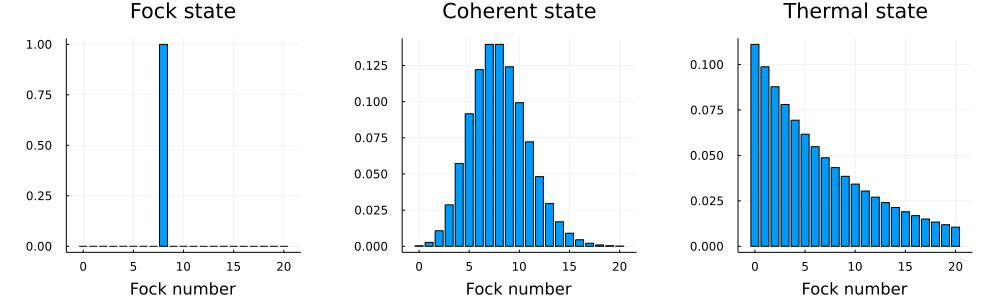

In [7]:
p_fock = plot(0:N, real(diag(dm(psi_fock).data)), seriestype=:bar, title="Fock state", legend=:none, xlabel="Fock number")
p_coherent = plot(0:N, real(diag(dm(psi_coherent).data)), seriestype=:bar, title="Coherent state", legend=:none, xlabel="Fock number")
p_thermal = plot(0:N, real(diag(rho_thermal.data)), seriestype=:bar, title="Thermal state", legend=:none, xlabel="Fock number")

plot(p_fock, p_coherent, p_thermal, layout=(1, 3), size=(1000, 300), margin=5mm)

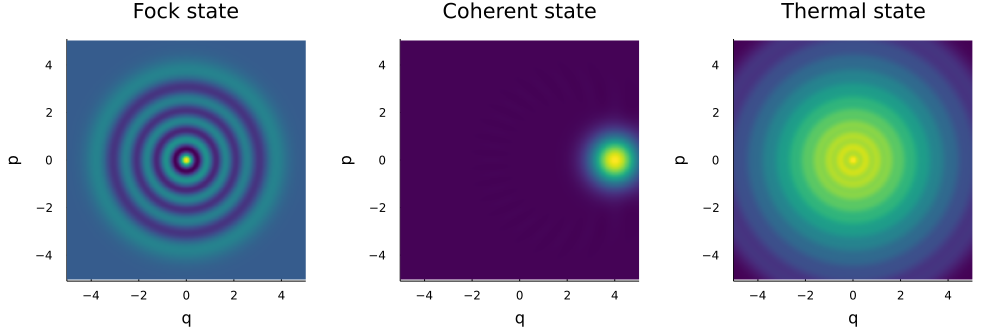

In [11]:
xvec = collect(LinRange(-5, 5, 201))
W_fock = wigner(dm(psi_fock), xvec, xvec)
W_coherent = wigner(dm(psi_coherent), xvec, xvec)
W_thermal = wigner(rho_thermal, xvec, xvec)

args = (seriestype = :heatmap, c = :viridis, aspect_ratio = :equal, colorbar = :none, grid = :none)
p1 = plot(xvec, xvec, W_fock; args..., title="Fock state", xlabel="q", ylabel="p")
p2 = plot(xvec, xvec, W_coherent'; args..., title="Coherent state", xlabel="q", ylabel="p")
p3 = plot(xvec, xvec, W_thermal; args..., title="Thermal state", xlabel="q", ylabel="p")

plot(p1, p2, p3, layout=(1, 3), size=(1000, 330), margin=5mm)

In [ ]:
plotattr(:Plot)


## Rotating wave approximation

main source: [Wikipedia](https://en.m.wikipedia.org/wiki/Rotating_wave_approximation)

In the rotating wave approximation, terms in a Hamiltonian which oscillate rapidly are neglected. This is a valid approximation when the applied electromagnetic radiation is near resonance with an atomic transition, and the intensity is low. Explicitly, terms in the Hamiltonians which oscillate with frequencies $\omega_L + \omega_0$ are neglected, while terms which oscillate with frequencies  $\omega_L - \omega_0$ are kept, where $\omega_L $ is the light frequency and $ \omega_0$ is a transition frequency.


For simplicity consider a two-level atomic system with ground and excited states $|\text{g}\rangle$ and $|\text{e}\rangle$, respectively. Let the energy difference between the states be $\hbar \omega_0$ so that $\omega_0$ is the transition frequency of the system. Then the unperturbed Hamiltonian of the atom can be written as
$$ 
H_0 = \frac{\hbar\omega_0}{2} \left(|\text{e}\rangle \langle\text{e}| - |\text{g}\rangle \langle\text{g}| \right).
$$


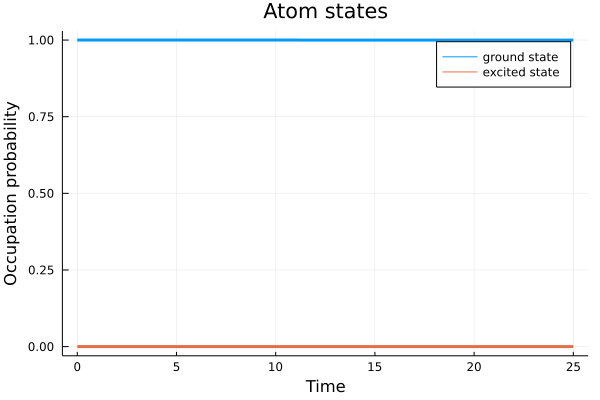

In [12]:
ħ = 1
omega_0 = 1.0 * 2π  # atom frequency

# bases
b_a = NLevelBasis(2)

g = nlevelstate(b_a, 1)
e = nlevelstate(b_a, 2)

# operators
gg = transition(b_a, 1, 1) # = g ⊗ dagger(g)
ee = transition(b_a, 2, 2) # = e ⊗ dagger(e)

# Hamiltonian
H_0 = ħ * omega_0 / 2 * ee - ħ * omega_0 / 2 * gg

# initial state
psi_0 = sqrt(1.) * g + sqrt(0.) * e 

# evolve the system
tspan = LinRange(0, 25, 1001);
tlist, rho_t = timeevolution.schroedinger(tspan, psi_0, H_0)

# ee = dagger(sm) * sm where sm = transition(b_a, 1, 2)

plot(tlist, [real(expect(gg, rho_t)), real(expect(ee, rho_t))];
    lw=3,
    label=["ground state" "excited state"],
    title="Atom states",
    xlabel="Time",
    ylabel="Occupation probability",
    ylims=[0,1]
)


Suppose the atom experiences an external classical electric field of frequency $\omega_L$, given by
$\vec{E}(t) = \vec{E}_0 e^{-i \omega_L t} +\vec{E}_0^* e^{i \omega_L t}$,
e.g. a plane wave propagating in space. 

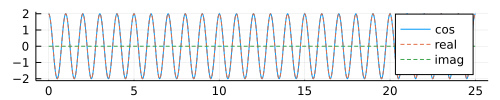

In [18]:
E_0 = 1 + 0im
omega_L = 1. * 2π 

# Note: 1/2 is missing 
E(t, E_0, omega_L) = E_0 * exp(-im * omega_L * t) + conj(E_0) * exp(im * omega_L * t)

Et = @. E(tspan, E_0, omega_L)

A, phi = abs(E_0), angle(E_0)
plot(tspan, 2 * A * cos.(omega_L * tspan .- phi), label="cos", size=(500,100))

plot!(tspan, real(Et), label="real", linestyle=:dash)
plot!(tspan, imag(Et), label="imag", linestyle=:dash)

Then under the dipole approximation the interaction Hamiltonian between the atom and the electric field can be expressed as
$$ H_1=-\vec{d}\cdot\vec{E},$$
where $\vec{d}$ is the dipole moment operator of the atom. The total Hamiltonian for the atom-light system is therefore $H = H_0 + H_1$. The atom does not have a dipole moment when it is in an energy eigenstate, so $\langle\text{e}| \vec{d} |\text{e}\rangle = \langle\text{g}| \vec{d} |\text{g}\rangle = 0.$ This means that defining $\vec{d}_{\text{eg}} := \langle\text{e}| \vec{d} |\text{g}\rangle$ allows the dipole operator to be written as
$$
\vec{d}=\vec{d}_{\text{eg}}|\text{e}\rangle\langle\text{g}|+\vec{d}_{\text{eg}}^*|\text{g}\rangle\langle\text{e}|.
$$ 

The interaction Hamiltonian can then be shown to be (see the Derivation section below)
$$
H_1 = -\hbar \left(\Omega e^{-i\omega_Lt} + \tilde{\Omega} e^{i\omega_Lt}\right) |\text{e}\rangle \langle\text{g}| - \hbar \left(\tilde{\Omega}^* e^{-i\omega_Lt} + \Omega^* e^{i\omega_Lt} \right)|\text{g}\rangle \langle\text{e}|
$$
where $\Omega = {\vec{d}_\text{eg} \cdot \vec{E}_0}/{\hbar}$ is the Rabi frequency and $\tilde{\Omega} := {\vec{d}_\text{eg} \cdot \vec{E}_0^*} / {\hbar}$ is the counter-rotating frequency. 

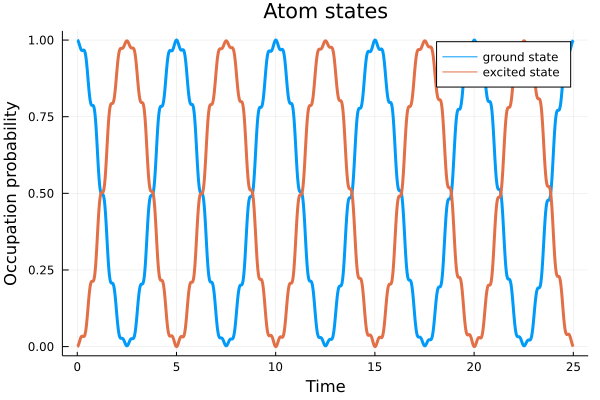

In [14]:
d_eg = .5 *  0.2 * 2π

# operators
ge = transition(b_a, 1, 2) 
eg = transition(b_a, 2, 1) 

# Rabi frequencies
Omega =        (d_eg * E_0) / ħ
Omega_tilde =  (d_eg * conj(E_0)) / ħ

# Hamiltonian
H_1(t) = - ħ * (Omega             * exp(-im * omega_L * t) + Omega_tilde * exp(im * omega_L * t)) * eg +
         - ħ * (conj(Omega_tilde) * exp(-im * omega_L * t) + conj(Omega) * exp(im * omega_L * t)) * ge

H_dynamic(t, psi) = H_0 + H_1(t)


# initial state
psi_0 = sqrt(1.) * g + sqrt(0.) * e 

# evolve the system
tspan = LinRange(0, 25, 1001);
tlist, rho_t = timeevolution.schroedinger_dynamic(tspan, psi_0, H_dynamic)

plot(tlist, [real(expect(gg, rho_t)), real(expect(ee, rho_t))];
    lw=3,
    label=["ground state" "excited state"],
    title="Atom states",
    xlabel="Time",
    ylabel="Occupation probability",
    ylims=[0,1]
)



To see why the $\tilde{\Omega}$ terms are called 'counter-rotating' consider a unitary transformation to the interaction or Dirac picture where the transformed Hamiltonian $H_{1,I}$ is given by
$$
H_{1,I} = -\hbar \left(\Omega e^{-i\Delta t} + \tilde{\Omega} e^{i (\omega_L + \omega_0) t}\right) |\text{e}\rangle \langle\text{g}|
-\hbar \left(\tilde{\Omega}^* e^{-i (\omega_L + \omega_0) t} + \Omega^* e^{i \Delta t}\right) |\text{g}\rangle \langle\text{e}|,
$$
where $\Delta := \omega_L - \omega_0$ is the detuning between the light field and the atom.

Note: $H_{1,I}  = H_{1} * e^{i \omega_0 t}$  

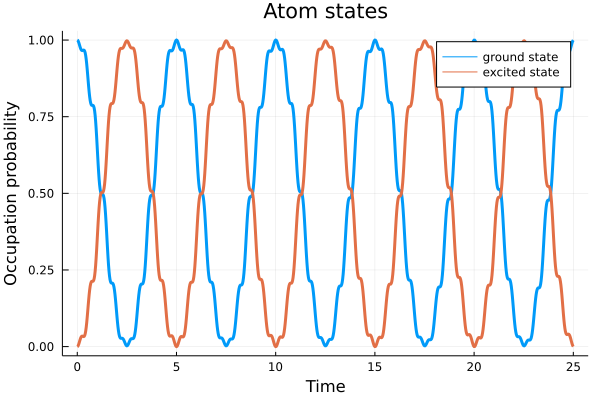

In [15]:
# Rabi frequencies
Delta = omega_L - omega_0

# Hamiltonian
H_I(t, psi) = - ħ * (Omega             * exp(-im * Delta * t)               + Omega_tilde * exp(im * (omega_L + omega_0) * t)) * eg +
              - ħ * (conj(Omega_tilde) * exp(-im * (omega_L + omega_0) * t) + conj(Omega) * exp(im * Delta * t)) * ge

# evolve the system
tlist, rho_t = timeevolution.schroedinger_dynamic(tspan, psi_0, H_I);

plot(tlist, [real(expect(gg, rho_t)), real(expect(ee, rho_t))];
    lw=3,
    label=["ground state" "excited state"],
    title="Atom states",
    xlabel="Time",
    ylabel="Occupation probability",
    ylims=[0,1]
)


### Making the approximation

This is the point at which the rotating wave approximation is made. The dipole approximation has been assumed, and for this to remain valid the electric field must be near resonance with the atomic transition. This means that $ \Delta \ll \omega_L + \omega_0 $ and the complex exponentials multiplying $\tilde{\Omega}$ and $\tilde{\Omega}^*$ can be considered to be rapidly oscillating. Hence on any appreciable time scale, the oscillations will quickly average to 0. The rotating wave approximation is thus the claim that these terms may be neglected and thus the Hamiltonian can be written in the interaction picture as
$$
H_{1,I}^{\text{RWA}}=-\hbar\Omega e^{-i\Delta t}|\text{e}\rangle\langle\text{g}|
 -\hbar\Omega^*e^{i\Delta t}|\text{g}\rangle\langle\text{e}|.
$$


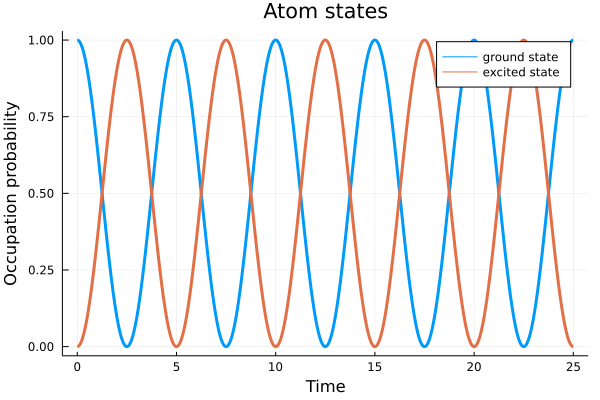

In [16]:
# Rabi frequencies
Delta = omega_L - omega_0

# Hamiltonian
H_I_RWA(t, psi) = - ħ * Omega       * exp(-im * Delta * t) * eg +
                  - ħ * conj(Omega) * exp( im * Delta * t) * ge

# evolve the system
tlist, rho_t = timeevolution.schroedinger_dynamic(tspan, psi_0, H_I_RWA);

plot(tlist, [real(expect(gg, rho_t)), real(expect(ee, rho_t))];
    lw=3,
    label=["ground state" "excited state"],
    title="Atom states",
    xlabel="Time",
    ylabel="Occupation probability",
    ylims=[0,1]
)



Finally, transforming back into the Schrödinger picture, the Hamiltonian is given by
$$
H^\text{RWA}=\frac{\hbar\omega_0}{2}|\text{e}\rangle\langle\text{e}|-
\frac{\hbar\omega_0}{2}|\text{g}\rangle\langle\text{g}|
-\hbar\Omega e^{-i\omega_Lt}|\text{e}\rangle\langle\text{g}|
-\hbar\Omega^*e^{i\omega_Lt}|\text{g}\rangle\langle\text{e}|.
$$
Another criterion for rotating wave approximation is the weak coupling condition, that is, the Rabi frequency should be much less than the transition frequency.



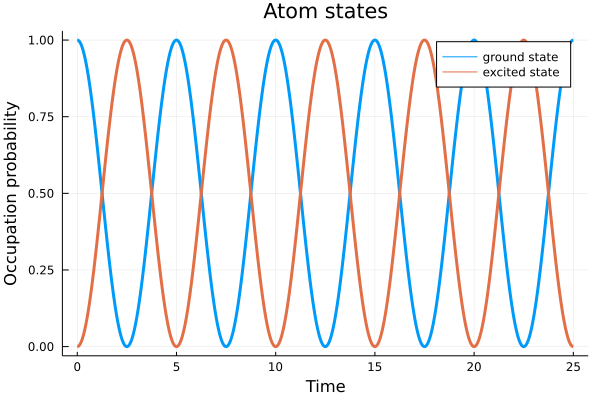

In [17]:
# Hamiltonian
H_1_RWA(t) = - ħ * Omega       * exp(-im * omega_L * t) * eg +
             - ħ * conj(Omega) * exp( im * omega_L * t) * ge

H_RWA(t, psi) = H_0 + H_1_RWA(t)

# evolve the system
tlist, rho_t = timeevolution.schroedinger_dynamic(tspan, psi_0, H_RWA);

plot(tlist, [real(expect(gg, rho_t)), real(expect(ee, rho_t))];
    lw=3,
    label=["ground state" "excited state"],
    title="Atom states",
    xlabel="Time",
    ylabel="Occupation probability",
    ylims=[0,1]
)

At this point the rotating wave approximation is complete. A common first step beyond this is to remove the remaining time dependence in the Hamiltonian via another unitary transformation.

### Derivation 

Given the above definitions the interaction Hamiltonian is
$$
\begin{align}
H_1 &= -\vec{d}\cdot\vec{E} \\
&=-\left(\vec{d}_\text{eg}|\text{e}\rangle\langle\text{g}|+\vec{d}_\text{eg}^*|\text{g}\rangle\langle\text{e}|\right)
  \cdot\left(\vec{E}_0e^{-i\omega_Lt}+\vec{E}_0^*e^{i\omega_Lt}\right) \\
&=-\left(\vec{d}_\text{eg}\cdot\vec{E}_0e^{-i\omega_Lt}
   +\vec{d}_\text{eg}\cdot\vec{E}_0^*e^{i\omega_Lt}\right)|\text{e}\rangle\langle\text{g}|
 -\left(\vec{d}_\text{eg}^*\cdot\vec{E}_0e^{-i\omega_Lt}
   +\vec{d}_\text{eg}^*\cdot\vec{E}_0^*e^{i\omega_Lt}\right)|\text{g}\rangle\langle\text{e}| \\
&=-\hbar\left(\Omega e^{-i\omega_Lt}+\tilde{\Omega}e^{i\omega_Lt}\right)|\text{e}\rangle\langle\text{g}|
 -\hbar\left(\tilde{\Omega}^*e^{-i\omega_Lt}+\Omega^*e^{i\omega_Lt}\right)|\text{g}\rangle\langle\text{e}|,
\end{align}
$$
as stated. The next step is to find the Hamiltonian in the interaction picture, $H_{1,I}$. The required unitary transformation is
$$
U = e^{iH_0t/\hbar} = e^{i \omega_0 t |\text{e}\rangle \langle\text{e}|} = |\text{g}\rangle \langle\text{g}| +e^{i \omega_0 t} |\text{e}\rangle \langle\text{e}|,
$$
where the last step can be seen to follow e.g. from a Taylor series expansion with the fact that $|\text{g}\rangle\langle\text{g}|+|\text{e}\rangle\langle\text{e}|=1$, and due to the orthogonality of the states $|\text{g}\rangle$ and $|\text{e}\rangle$. The substitution for $H_0$ in the second step being different from the definition given in the previous section can be justified either by shifting the overall energy levels such that $|\text{g}\rangle$ has energy $0$ and $|\text{e}\rangle$ has energy $\hbar \omega_0$, or by noting that a multiplication by an overall phase ($e^{i \omega_0 t/2}$ in this case) on a unitary operator does not affect the underlying physics. We now have

$$
\begin{align}
H_{1,I} &\equiv U H_1 U^\dagger \\
&=-\hbar\left(\Omega e^{-i\omega_Lt}+\tilde{\Omega}e^{i\omega_Lt}\right)e^{i\omega_0t}|\text{e}\rangle\langle\text{g}|
 -\hbar\left(\tilde{\Omega}^*e^{-i\omega_Lt}+\Omega^*e^{i\omega_Lt}\right)|\text{g}\rangle\langle\text{e}|e^{-i\omega_0t} \\
&=-\hbar\left(\Omega e^{-i\Delta t}+\tilde{\Omega}e^{i(\omega_L+\omega_0)t}\right)|\text{e}\rangle\langle\text{g}|
 -\hbar\left(\tilde{\Omega}^*e^{-i(\omega_L+\omega_0)t}+\Omega^*e^{i\Delta t}\right)|\text{g}\rangle\langle\text{e}|\ .
\end{align}
$$

Now we apply the RWA by eliminating the counter-rotating terms as explained in the previous section, and finally transform the approximate Hamiltonian $H_{1,I}^{\text{RWA}}$ back to the Schrödinger picture:

$$\begin{align}
H_1^{\text{RWA}}&=U^\dagger H_{1,I}^{\text{RWA}} U \\
&=-\hbar\Omega e^{-i\Delta t}e^{-i\omega_0t}|\text{e}\rangle\langle\text{g}|
 -\hbar\Omega^*e^{i\Delta t}|\text{g}\rangle\langle\text{e}|e^{i\omega_0t} \\
&=-\hbar\Omega e^{-i\omega_Lt}|\text{e}\rangle\langle\text{g}|
 -\hbar\Omega^*e^{i\omega_Lt}|\text{g}\rangle\langle\text{e}|.
\end{align}$$

The atomic Hamiltonian was unaffected by the approximation, so the total Hamiltonian in the Schrödinger picture under the rotating wave approximation is
$$
H^\text{RWA}=H_0+H_1^{\text{RWA}} = \frac{\hbar\omega_0}{2}|\text{e}\rangle\langle\text{e}|-
\frac{\hbar\omega_0}{2}|\text{g}\rangle\langle\text{g}|
-\hbar\Omega e^{-i\omega_Lt}|\text{e}\rangle\langle\text{g}|
-\hbar\Omega^*e^{i\omega_Lt}|\text{g}\rangle\langle\text{e}|.
$$


